# Credit Risk Module: When Borrowers Default

**Focus:** Internal Ratings Based (IRB) parameters — **Probability of Default (PD)**, **Loss Given Default (LGD)**, and **Exposure at Default (EAD)** — and how they interact to drive **expected loss (EL)** and **unexpected loss (UL)**.

Students will run a **Monte Carlo** simulation of a loan portfolio with **correlated defaults** and apply **macroeconomic stress multipliers** to assess solvency. They’ll also compare simulated capital needs with the **Basel IRB (ASRF) capital approximation**.

## Learning Objectives
- Define and use **PD, LGD, EAD** to compute EL and UL.
- Simulate **default correlations** via a one‑factor Gaussian model.
- Apply **macro stress** multipliers to PD and/or LGD.
- Compare Monte Carlo **economic capital** to a **Basel IRB** approximation.
- Interpret how **systemic shocks** and **correlations** amplify capital requirements.

## Setup

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
rng = np.random.default_rng(12345)


## Parameters

In [2]:
# Portfolio size and exposure units (e.g., £)
N_LOANS = 20000
AVG_EAD = 10_000.0

# Base PD and LGD distributions (stylised)
PD_MEAN = 0.06     # average 6% one-year PD
PD_STD  = 0.03     # heterogeneity across borrowers
LGD_MEAN = 0.55
LGD_STD  = 0.15

# Correlation (ASRF asset correlation)
RHO = 0.12

# Macro stress multipliers
STRESS = {
    'Baseline': {'PD_mult': 1.00, 'LGD_mult': 1.00},
    'Mild Downturn': {'PD_mult': 1.25, 'LGD_mult': 1.05},
    'Severe Recession': {'PD_mult': 1.75, 'LGD_mult': 1.10},
}

# Capital & VaR confidence
STARTING_CAPITAL = 150_000_000.0
CONF_LEVEL = 0.999


## Build a Synthetic IRB Portfolio

In [3]:
# Generate EADs (lognormal for positive skew) and idiosyncratic PD/LGD
EAD = rng.lognormal(mean=math.log(AVG_EAD), sigma=0.6, size=N_LOANS)

# PDs clipped to reasonable bounds
PD_raw = np.clip(rng.normal(PD_MEAN, PD_STD, size=N_LOANS), 1e-4, 0.40)

# LGDs from a clipped normal (educational); in practice use beta or segment models
LGD_raw = np.clip(rng.normal(LGD_MEAN, LGD_STD, size=N_LOANS), 0.1, 0.95)

portfolio = pd.DataFrame({'EAD': EAD, 'PD': PD_raw, 'LGD': LGD_raw})
portfolio.describe()


,EAD,PD,LGD
count,"20,000.000000","20,000.000000","20,000.000000"
mean,"12,025.668750",0.060278,0.550162
std,"7,909.299795",0.029295,0.149184
min,"1,009.497486",0.000100,0.100000
25%,"6,705.145673",0.039912,0.450474
50%,"10,119.041362",0.059970,0.551161
75%,"15,001.114696",0.080114,0.651254
max,"149,911.950093",0.179038,0.950000


## Key Quantities
- **Expected Loss (EL)** = PD × LGD × EAD (aggregated across loans)
- **Unexpected Loss (UL)** = tail quantile loss − EL (here tail via VaR at chosen confidence)
- **Basel IRB capital approximation (ASRF)** per exposure:
  
  For PD ∈ (0,1), LGD ∈ (0,1), asset correlation ρ, confidence α:
  
  \[ K = \text{LGD}\,\Phi\!\left(\frac{\Phi^{-1}(\text{PD}) + \sqrt{\rho}\,\Phi^{-1}(\alpha)}{\sqrt{1-\rho}}\right) - \text{PD}\cdot\text{LGD} \]
  
(Educational simplification; excludes maturity adjustment and jurisdictional specifics.)

## Helper Functions

In [4]:
from scipy.stats import norm

def vasicek_capital_per_exposure(pd, lgd, rho, alpha=0.999):
    pd = np.clip(pd, 1e-8, 1-1e-8)
    z = (norm.ppf(pd) + math.sqrt(rho)*norm.ppf(alpha)) / math.sqrt(1.0 - rho)
    k = lgd*norm.cdf(z) - pd*lgd
    return np.maximum(k, 0.0)

def one_factor_mc_losses(EAD, PD, LGD, rho, n_scenarios=5000, seed=123):
    rng = np.random.default_rng(seed)
    n = len(EAD)
    Z = rng.standard_normal(n_scenarios)
    sqrt_r = math.sqrt(rho)
    sqrt_1mr = math.sqrt(1-rho)
    kappa = norm.ppf(np.clip(PD, 1e-8, 1-1e-8))
    losses = np.zeros(n_scenarios)
    batch = 5000
    for i0 in range(0, n, batch):
        i1 = min(i0+batch, n)
        e = np.asarray(EAD[i0:i1])
        l = np.asarray(LGD[i0:i1])
        k = np.asarray(kappa[i0:i1])
        eps = rng.standard_normal((n_scenarios, i1-i0))
        L = sqrt_r*Z[:,None] + sqrt_1mr*eps
        D = (L < k)
        losses += (D * (e[None,:]*l[None,:])).sum(axis=1)
    return losses


## Monte Carlo Under Baseline and Stress

In [5]:
summary_rows = []
results = {}

for scen, mults in STRESS.items():
    pd_mult = mults['PD_mult']
    lgd_mult = mults['LGD_mult']
    PD_s = np.clip(portfolio['PD'].to_numpy()*pd_mult, 1e-5, 0.90)
    LGD_s = np.clip(portfolio['LGD'].to_numpy()*lgd_mult, 0.05, 0.99)
    EAD_s = portfolio['EAD'].to_numpy()

    losses = one_factor_mc_losses(EAD_s, PD_s, LGD_s, RHO, n_scenarios=4000, seed=2024)
    results[scen] = losses

    EL = (PD_s*LGD_s*EAD_s).sum()
    VaR = np.quantile(losses, CONF_LEVEL)
    UL = VaR - EL

    # Basel IRB approximation (sum of K across loans)
    K_per = vasicek_capital_per_exposure(PD_s, LGD_s, RHO, alpha=CONF_LEVEL)
    K_sum = (K_per * EAD_s).sum()

    solv_ratio = max(0.0, STARTING_CAPITAL - UL) / EAD_s.sum()

    summary_rows.append({
        'Scenario': scen,
        'Expected Loss (£)': EL,
        f'VaR {int(CONF_LEVEL*1000)/10:.1f}% (£)': VaR,
        'UL = VaR-EL (£)': UL,
        'IRB Approx Capital (£)': K_sum,
        'Toy Solvency Ratio': solv_ratio,
        'Total EAD (£)': EAD_s.sum(),
    })

summary = pd.DataFrame(summary_rows).set_index('Scenario')
summary


,Expected Loss (£),VaR 99.9% (£),UL = VaR-EL (£),IRB Approx Capital (£),Toy Solvency Ratio,Total EAD (£)
Scenario,,,,,,
Baseline,"7,982,698.917920","40,583,365.263033","32,600,666.345113","30,437,550.119643",0.488120,"240,513,375.002614"
Mild Downturn,"10,476,836.179971","48,561,962.048761","38,085,125.868790","35,655,130.662449",0.465317,"240,513,375.002614"
Severe Recession,"15,358,221.755112","61,275,324.936687","45,917,103.181575","43,277,138.044432",0.432753,"240,513,375.002614"


### Loss Distributions

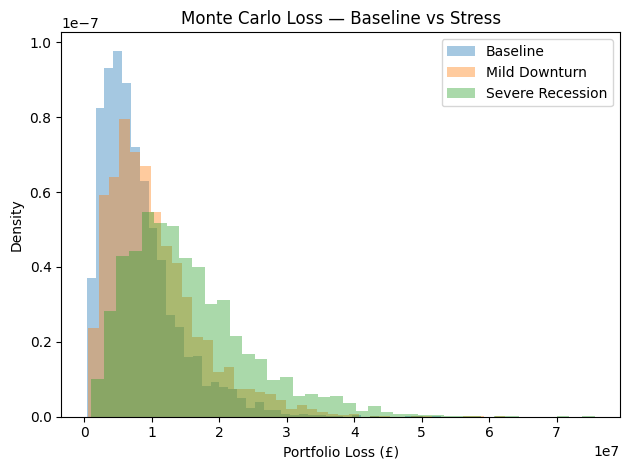

In [6]:
plt.figure()
for scen, losses in results.items():
    plt.hist(losses, bins=40, density=True, alpha=0.4, label=scen)
plt.xlabel('Portfolio Loss (£)')
plt.ylabel('Density')
plt.title('Monte Carlo Loss — Baseline vs Stress')
plt.legend()
plt.tight_layout()
plt.show()


### Economic Capital (UL) vs IRB Approximation

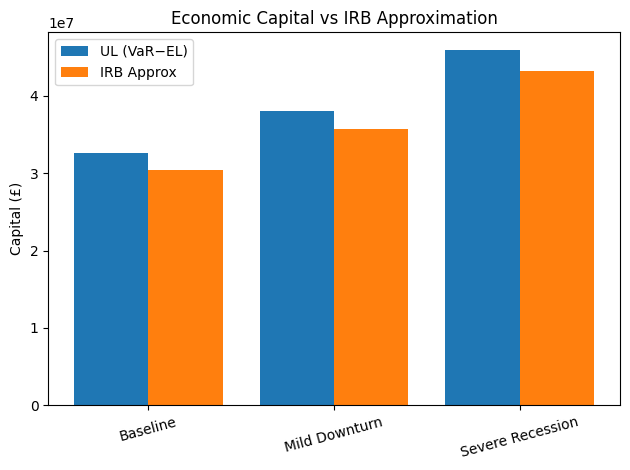

In [7]:
labels = list(results.keys())
UL_vals = [summary.loc[k, 'UL = VaR-EL (£)'] for k in labels]
IRB_vals = [summary.loc[k, 'IRB Approx Capital (£)'] for k in labels]

x = np.arange(len(labels))
plt.figure()
plt.bar(x-0.2, UL_vals, width=0.4, label='UL (VaR−EL)')
plt.bar(x+0.2, IRB_vals, width=0.4, label='IRB Approx')
plt.xticks(x, labels, rotation=15)
plt.ylabel('Capital (£)')
plt.title('Economic Capital vs IRB Approximation')
plt.legend()
plt.tight_layout()
plt.show()


### Sensitivity to Default Correlation (ρ)

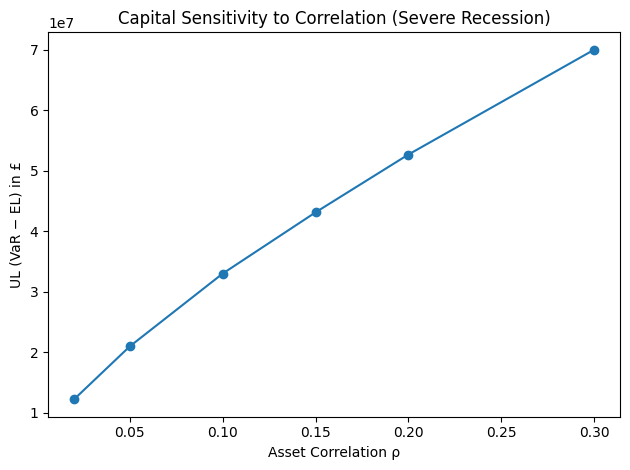

In [8]:
PD_s = np.clip(portfolio['PD'].to_numpy()*STRESS['Severe Recession']['PD_mult'], 1e-5, 0.90)
LGD_s = np.clip(portfolio['LGD'].to_numpy()*STRESS['Severe Recession']['LGD_mult'], 0.05, 0.99)
EAD_s = portfolio['EAD'].to_numpy()

rhos = [0.02, 0.05, 0.10, 0.15, 0.20, 0.30]
ULs = []
for r in rhos:
    losses = one_factor_mc_losses(EAD_s, PD_s, LGD_s, r, n_scenarios=3000, seed=777)
    EL = (PD_s*LGD_s*EAD_s).sum()
    VaR = np.quantile(losses, CONF_LEVEL)
    ULs.append(VaR - EL)

plt.figure()
plt.plot(rhos, ULs, marker='o')
plt.xlabel('Asset Correlation ρ')
plt.ylabel('UL (VaR − EL) in £')
plt.title('Capital Sensitivity to Correlation (Severe Recession)')
plt.tight_layout()
plt.show()


## Exercises
1. **Macro stress design:** Edit `STRESS` multipliers for PD and LGD; re-run. Which driver has the bigger impact on capital?
2. **Heterogeneity:** Segment the portfolio by PD buckets and compare UL/IRB across segments.
3. **Link to solvency ratios:** Add a simple balance sheet (Assets, Liabilities, CET1) and compute CET1/Leverage under each stress.
4. **Backtest vs IRB:** Replace synthetic PD/LGD with your estimates from real data and compare to the IRB approximation.


## Export Summary

In [10]:
out_path = Path('credit_risk_irb_summary.csv')
summary.to_csv(out_path)
out_path


PosixPath('credit_risk_irb_summary.csv')